In [1]:
import pandas as pd
df_ff_train = pd.read_csv("tep_faultfree_training.csv")
df_ff_test = pd.read_csv("tep_faultfree_testing.csv")
df_f_train = pd.read_csv("tep_faulty_training.csv")
df_f_test = pd.read_csv("tep_faulty_testing.csv")

df_ff_train["label"] = 0
df_f_train["label"] = 1
df_ff_test["label"] = 0
df_f_test["label"] = 1

df_train_combined = pd.concat(
    [df_ff_train, df_f_train],
    axis=0,          
    ignore_index=True
)

df_test_combined = pd.concat(
    [df_ff_test, df_f_test],
    axis=0,
    ignore_index=True
)

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_df(df, scaler):

    features_scaled = scaler.transform(df.iloc[:, :55])
    labels = df.iloc[:, 55:56].to_numpy().reshape(-1, 1)
    X_scaled = np.hstack([features_scaled, labels])
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

    return df_scaled

scaler = StandardScaler()
scaler.fit(df_ff_train.iloc[:, :55])
df_ff_train = scale_df(df_ff_train, scaler)
df_test_combined = scale_df(df_test_combined, scaler)
df_train_combined = scale_df(df_train_combined, scaler)


## PCA setup - same as task 1

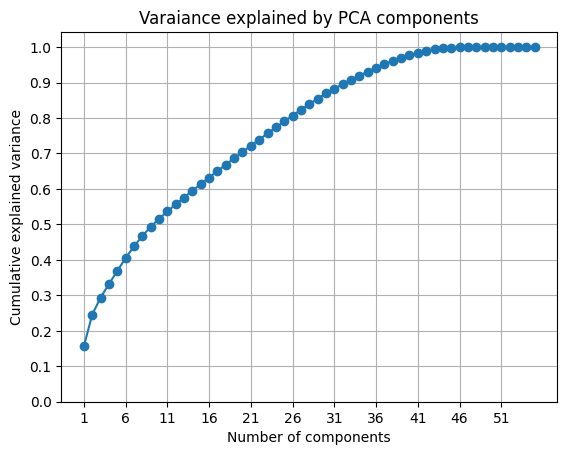

Explained variance by the first 10 components:
PC1: 15.59%
PC2: 8.92%
PC3: 4.83%
PC4: 3.79%
PC5: 3.73%
PC6: 3.63%
PC7: 3.29%
PC8: 2.93%
PC9: 2.59%
PC10: 2.23%


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train = df_ff_train.iloc[:, :55].values
y_train = df_ff_train["label"].values

X_test = df_test_combined.iloc[:, :55].values
y_test = df_test_combined["label"].values

pca3 = PCA(n_components=55)
pca3.fit(X_train)

x = np.arange(1, len(pca3.explained_variance_ratio_[0:-1]) + 2)

plt.plot(x,np.cumsum(pca3.explained_variance_ratio_),marker='o')
plt.title('Varaiance explained by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(1, 56, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

print("Explained variance by the first 10 components:")
for i in range(10):
    print(f"PC{i+1}: {pca3.explained_variance_ratio_[i]*100:.2f}%")


pca3 = PCA(n_components=21)
pca3.fit(X_train)

X_test_pca = pca3.transform(X_test)
X_train_pca = pca3.transform(X_train)

## KMeans clustering

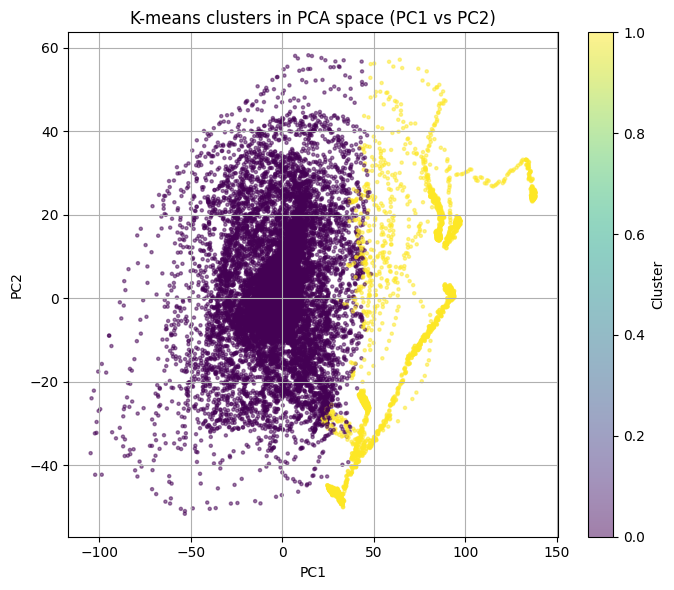

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 2
kmeans = KMeans(n_clusters=k, random_state=69, n_init='auto').fit(X_test_pca)
cluster_test = kmeans.predict(X_test_pca)

plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=cluster_test,     
    cmap='viridis',
    s=5,
    alpha=0.5
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space (PC1 vs PC2)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

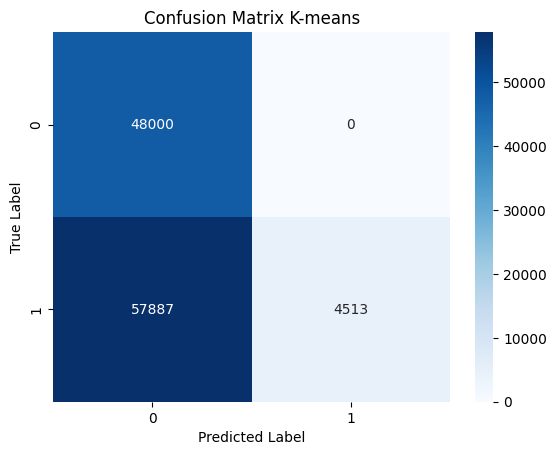

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62     48000
         1.0       1.00      0.07      0.13     62400

    accuracy                           0.48    110400
   macro avg       0.73      0.54      0.38    110400
weighted avg       0.76      0.48      0.35    110400



In [4]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(y_test, cluster_test)
# Plot
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix K-means")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, cluster_test))

## DBSCAN

### KNN elbow

In [5]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_test_pca)
distances, indices = neighbors_fit.kneighbors(X_test_pca)
distances = np.sort(distances[:, -1])

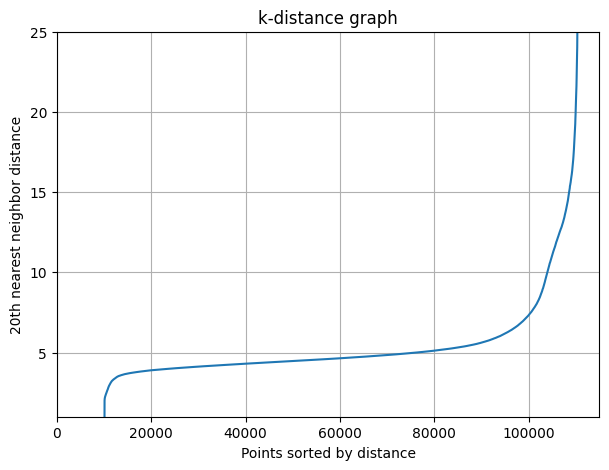

In [6]:
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("20th nearest neighbor distance")
plt.xlim(00000, 115000)
plt.ylim(1, 25)
plt.grid(True)
plt.show()

In [7]:
from sklearn.cluster import DBSCAN

eps_values = [3, 3.2, 3.4, 3.6, 3.8]
min_samples_list = [10, 15, 20, 25]

results = []  # store results for each eps

for eps in eps_values:
        
    for min_samples in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1, algorithm="brute").fit(X_test_pca)
        db_labels = db.labels_

        # Convert DBSCAN labels: outlier = -1 -> treat as faulty (1)
        y_pred = np.where(db_labels == -1, 1, 0)

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Compute metrics
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        fnr = fn / (fn + tp + 1e-10)
        fpr = fp / (fp + tn + 1e-10)

        outliers = np.sum(db_labels == -1)
        ratio_outliers = outliers / (np.sum(y_test == 1) + 1e-10)

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "fnr": fnr,
            "fpr": fpr,
            "outliers": outliers,
            "outlier_ratio": ratio_outliers,
            "y_pred": y_pred
        })


In [8]:
results_df = pd.DataFrame(results)
results_df.iloc[:,:9]

,eps,min_samples,precision,recall,f1,fnr,fpr,outliers,outlier_ratio
0,3.0,10,0.502602,0.758381,0.604550,0.241619,0.975687,94156,1.508910
1,3.0,15,0.515773,0.805721,0.628938,0.194279,0.983375,97479,1.562163
2,3.0,20,0.519295,0.818397,0.635407,0.181603,0.984854,98341,1.575978
3,3.0,25,0.557122,0.962196,0.705659,0.037804,0.994354,107770,1.727083
4,3.2,10,0.495076,0.725000,0.588373,0.275000,0.961250,91380,1.464423
5,3.2,15,0.512472,0.790192,0.621728,0.209808,0.977250,96216,1.541923
6,3.2,20,0.516858,0.806795,0.630072,0.193205,0.980417,97404,1.560962
7,3.2,25,0.553420,0.943830,0.697725,0.056170,0.990104,106420,1.705449
8,3.4,10,0.488215,0.670833,0.565137,0.329167,0.914187,85741,1.374054
9,3.4,15,0.508767,0.756106,0.608253,0.243894,0.949062,92736,1.486154


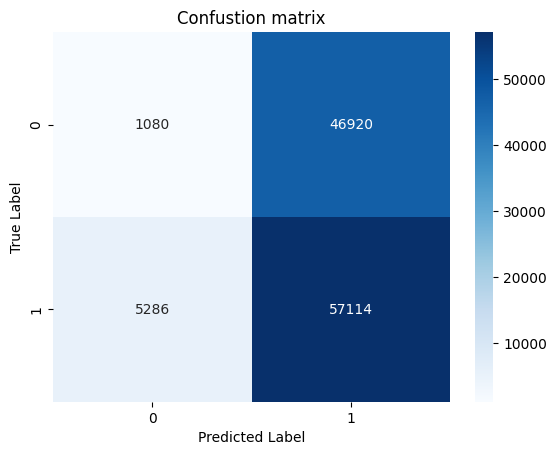

              precision    recall  f1-score   support

         0.0       0.17      0.02      0.04     48000
         1.0       0.55      0.92      0.69     62400

    accuracy                           0.53    110400
   macro avg       0.36      0.47      0.36    110400
weighted avg       0.38      0.53      0.41    110400



In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = results_df.loc[11, "y_pred"]
cm2 = confusion_matrix(y_test, y_pred)

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title("Confustion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


### PLots and stuff

Cluster: 52
Outliers: 84451
Split outliers: 76.5 %


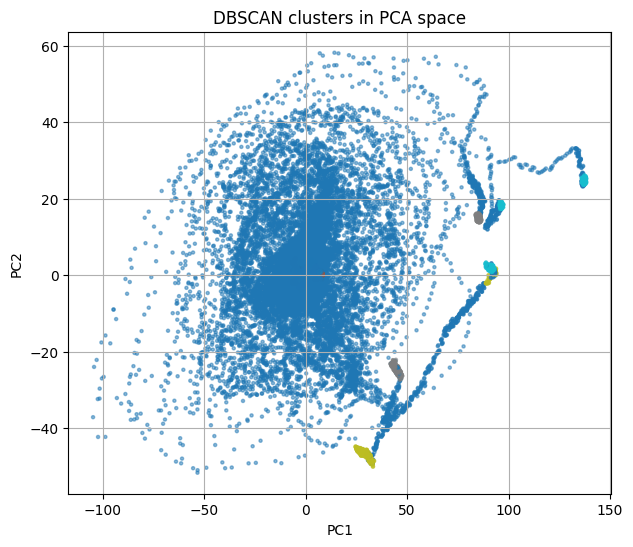

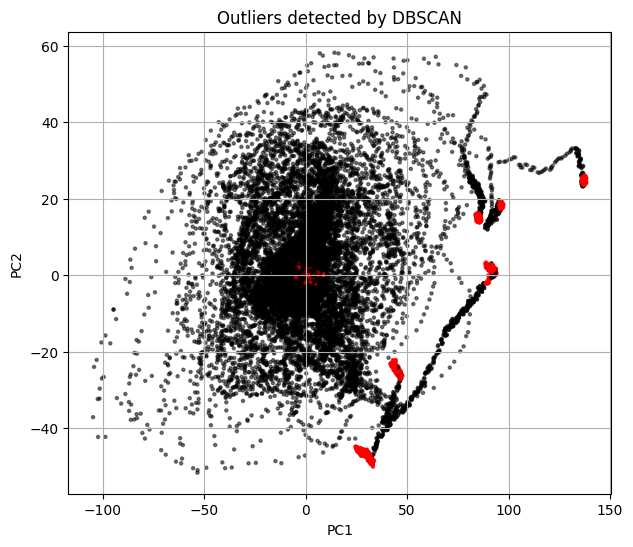

KeyError: 'dbscan'

In [10]:
n_outliers = np.sum(db_labels == -1)
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

print("Cluster:", n_clusters)
print("Outliers:", n_outliers)
print("Split outliers:", round(n_outliers / len(db_labels) * 100, 2), "%")

plt.figure(figsize=(7,6))
plt.scatter(
    X_test_pca[:,0],
    X_test_pca[:,1],
    c=db_labels,
    cmap="tab10",
    s=5,
    alpha=0.5
)
plt.title("DBSCAN clusters in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

colors = np.where(db_labels == -1, "black", "red")

plt.figure(figsize=(7,6))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=colors, s=5, alpha=0.5)
plt.title("Outliers detected by DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# true labels: 0 = normal, 1 = fault
faults = df_test_combined["label"] == 1
normals = df_test_combined["label"] == 0
outliers = df_test_combined["dbscan"] == -1

fault_detection_rate = np.mean(outliers[faults]) * 100
false_alarm_rate = np.mean(outliers[normals]) * 100

print("Fault detection rate:", round(fault_detection_rate, 2), "%")
print("False alarm rate:", round(false_alarm_rate, 2), "%")

pred = np.where(db_labels == -1, 1, 0)

cf= confusion_matrix(y_test, pred)
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix DBSCAN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, pred))

colors = np.where(db_labels == -1, "black", np.where(y_test==1, "red", "blue"))

plt.figure(figsize=(7,6))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=colors, s=5, alpha=0.5)
plt.title("DBSCAN Outlier Detection vs True Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## HDBSCAN

In [ ]:
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(
            min_cluster_size=50,      
            min_samples=20,           
            cluster_selection_epsilon=0.0
)
hdb_labels = hdb.fit_predict(X_test_pca)   # -1 = outlier
df_test_combined["hdbscan"] = hdb_labels

In [ ]:
outliers = df_test_combined["hdbscan"] == -1
faults   = df_test_combined["label"] == 1

print("Faults detected as outliers:", 
      np.mean(outliers[faults]) * 100, "%")

print("Normal detected as outliers:",
      np.mean(outliers[~faults]) * 100, "%")


plt.figure(figsize=(7,6))
plt.scatter(
      X_test_pca[:,0], X_test_pca[:,1],
      c=df_test_combined["hdbscan"],
      cmap='tab10', s=5, alpha=0.5
)
plt.title("HDBSCAN clustering in PCA space")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

labels = df_test_combined["hdbscan"]
colors = np.where(labels == -1, "black","red")

plt.figure(figsize=(7,6))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=colors, s=5, alpha=0.5)
plt.title("Outliers detected by HDBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()